#Model
This file builds a Machine Learning Model for the prediction of agitation in
People Living With Dementia, using a Dataset from TIHM.
https://github.com/PBarnaghi/TIHM-Dataset

#0. Configuration
Importing libraries, Preparation of Dataset

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Import dataset from drive as csv
activity = pd.read_csv("/content/drive/MyDrive/TIHM_Dataset/Dataset/Activity.csv") #data hosted on my personal drive, may change according to use
physiology = pd.read_csv("/content/drive/MyDrive/TIHM_Dataset/Dataset/Physiology.csv")
labels = pd.read_csv("/content/drive/MyDrive/TIHM_Dataset/Dataset/Labels.csv")

# 1. Exploratory Data Analysis






In [5]:
#Activity Data description
print(f"Activity data description: \n{activity.describe()}")

#field names for activity
print(f"\nactivity fields: \n{activity.columns})")

print("---")
#Physiology Data description
print(f"Physiology data description: \n{physiology.describe(include = 'all')}")

#field names for physiology

print(f"\physiology fields: \n{physiology.columns})")



Activity data description: 
       patient_id location_name                 date
count     1030559       1030559              1030559
unique         56             8               916821
top         b9d58       Kitchen  2019-06-20 14:23:25
freq        46654        227312                    6

activity fields: 
Index(['patient_id', 'location_name', 'date'], dtype='object'))
---
Physiology data description: 
       patient_id                 date       device_type         value   unit
count       17679                17679             17679  17679.000000  17679
unique         55                 9773                 8           NaN      5
top         c55f8  2019-06-28 10:16:06  Body Temperature           NaN    Cel
freq          951                    6              5617           NaN   6362
mean          NaN                  NaN               NaN     64.766046    NaN
std           NaN                  NaN               NaN     33.999335    NaN
min           NaN                  NaN      

It appears that all other subsets of data, except for activity is recorded quite sparsely, the record density is rather low to give promising results. We limit our scope into predicting agitation purely from activity data

#2. Data Preprocessing

In [6]:
#discard days in which there are less than 50 daily entries
MIN_DAILY_ENTRY = 50
print(activity)
activity['date'] = pd.to_datetime(activity['date'])
activity['day'] = activity['date'].dt.date
activity_grouped = activity.groupby(['patient_id', 'day']).size().reset_index(name='entry_count')


activity_grouped = activity_grouped[activity_grouped['entry_count'] >= MIN_DAILY_ENTRY]

activity_valid = activity_grouped.drop_duplicates(subset=('patient_id', 'day'))[['patient_id', 'day']]
print(activity_valid)
activity = pd.merge(activity_valid, activity, on=['patient_id', 'day'])
print(activity)

        patient_id location_name                 date
0            0697d   Fridge Door  2019-06-28 13:03:29
1            0697d       Kitchen  2019-06-28 13:11:44
2            0697d    Front Door  2019-06-28 13:13:50
3            0697d       Bedroom  2019-06-28 13:13:53
4            0697d   Fridge Door  2019-06-28 13:14:09
...            ...           ...                  ...
1030554      fd100       Hallway  2019-06-30 23:48:50
1030555      fd100        Lounge  2019-06-30 23:49:40
1030556      fd100       Kitchen  2019-06-30 23:50:02
1030557      fd100    Front Door  2019-06-30 23:51:28
1030558      fd100    Front Door  2019-06-30 23:51:36

[1030559 rows x 3 columns]
     patient_id         day
0         0697d  2019-06-28
1         0697d  2019-06-29
2         0697d  2019-06-30
3         099bc  2019-05-15
4         099bc  2019-05-16
...         ...         ...
2717      f220c  2019-06-30
2718      fd100  2019-06-27
2719      fd100  2019-06-28
2720      fd100  2019-06-29
2721      fd100 

Segment our data into 1 hour intervals.


Note: the underlying assumption is that information is only relevant within a one hour window, which may be an oversight.

In [7]:
#group data into 1 hour intervals
activity_g2 = activity.groupby(['patient_id', pd.Grouper(key='date', freq = '1H')])['location_name'].apply(np.array)
activity_g3 = activity.groupby(['patient_id', pd.Grouper(key='date', freq = '1H')])['date'].apply(np.array)

#create new dataframe with new column, encoding the time and location into a 2d array
activity_g4 = pd.DataFrame({'datetime': activity_g3, 'location_name': activity_g2}).reset_index()
activity_g4['joint'] = activity_g4.apply(lambda row: np.array([np.array(x) for x in zip(row['datetime'], row['location_name'])]), axis=1)
activity_g4 = activity_g4.drop(["datetime", "location_name"], axis = 1)

Preprocess the data labels

In [8]:
#only take the agitation type
labels = labels[labels['type'] == 'Agitation']
labels['date'] = pd.to_datetime(labels['date'])

#align to activity data
labels_grouped = labels.groupby(['patient_id', pd.Grouper(key='date', freq = '1H')]).sum().reset_index()
print(labels_grouped.head(50))

activity_labels = pd.merge(activity_g4, labels_grouped, on = ['patient_id', 'date'], how = 'outer')
activity_labels = activity_labels.dropna(subset = ['joint'])
activity_labels = activity_labels.fillna(0)
activity_labels['type'] = activity_labels['type'].replace('Agitation', 1)


print("negative count:")
print(activity_labels[activity_labels['type'] == 0].shape[0])
print("positive count:")
print(activity_labels[activity_labels['type'] == 1].shape[0])

   patient_id                date       type
0       099bc 2019-06-10 12:00:00  Agitation
1       0cda9 2019-05-28 12:00:00  Agitation
2       0d5ef 2019-05-23 12:00:00  Agitation
3       0d5ef 2019-05-24 12:00:00  Agitation
4       0d5ef 2019-05-25 12:00:00  Agitation
5       0d5ef 2019-05-25 18:00:00  Agitation
6       0d5ef 2019-05-29 12:00:00  Agitation
7       0d5ef 2019-06-01 12:00:00  Agitation
8       0d5ef 2019-06-02 12:00:00  Agitation
9       0d5ef 2019-06-03 12:00:00  Agitation
10      0d5ef 2019-06-09 18:00:00  Agitation
11      0d5ef 2019-06-26 18:00:00  Agitation
12      0d5ef 2019-06-28 18:00:00  Agitation
13      16f4b 2019-04-11 12:00:00  Agitation
14      16f4b 2019-04-14 12:00:00  Agitation
15      16f4b 2019-04-15 18:00:00  Agitation
16      16f4b 2019-04-16 18:00:00  Agitation
17      16f4b 2019-04-21 12:00:00  Agitation
18      16f4b 2019-04-22 12:00:00  Agitation
19      16f4b 2019-04-26 12:00:00  Agitation
20      16f4b 2019-05-10 12:00:00  Agitation
21      16

<ipython-input-8-3e8fbd0e5732>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['date'] = pd.to_datetime(labels['date'])


#3. Data Augmentation


We see that there is a severe class imbalance with a lack of positive data. We try data augmentation through shifting each activity t minutes to the left and right.



In [9]:
pos_activity = activity_labels[activity_labels['type'] == 1]
neg_activity = activity_labels[activity_labels['type'] == 0]


In [10]:
def ActivityShift(timearr, t, is_left = True):
  """
  Obtain augmented copy of the event array shifted by t minutes
  Args:
    timearr (np.array): time array to be shifted
    t (int): number of minutes to be shifted before or after
    is_left (bool): left shifting, if set to false, performs right shifting, defaulted to True
  Return:
    r_retarr (np.array): right shifted time array
    l_retarr (np.array): right shifted time array
  """


  retarr = []


  for event in timearr:

    ts, loc = event[0], event[1]

    if (is_left):
      l_ts = ts - pd.Timedelta(minutes = t)
      if (pd.to_datetime(ts).minute < (t+1)):
        continue
      else:
        retarr.append(np.array([l_ts, loc]))



    else:
      r_ts = ts + pd.Timedelta(minutes = t)
      if (pd.to_datetime(ts).minute > (60-t-1)):
        continue
      else:
        retarr.append(np.array([r_ts, loc]))


  return np.array(retarr)





In [11]:
pos_act_a1 = pos_activity.copy()
pos_act_a2 = pos_activity.copy()
pos_act_a3 = pos_activity.copy()
pos_act_a4 = pos_activity.copy()
pos_act_a5 = pos_activity.copy()
pos_act_a5 = pos_activity.copy()
pos_act_a6 = pos_activity.copy()
pos_act_a7 = pos_activity.copy()
pos_act_a8 = pos_activity.copy()

pos_act_a9 = pos_activity.copy()
pos_act_a10 = pos_activity.copy()
pos_act_a11 = pos_activity.copy()
pos_act_a12 = pos_activity.copy()
pos_act_a13 = pos_activity.copy()
pos_act_a14 = pos_activity.copy()
pos_act_a15 = pos_activity.copy()
pos_act_a16 = pos_activity.copy()


def Augment(row, t = 3, left = True):
  return ActivityShift(row['joint'], t, left)


pos_act_a1.loc[:, 'joint'] = pos_act_a1.apply(Augment, axis = 1, args = (3, True))
pos_act_a2.loc[:, 'joint'] = pos_act_a2.apply(Augment, axis = 1, args = (3, False))
pos_act_a3.loc[:, 'joint'] = pos_act_a3.apply(Augment, axis = 1, args = (5, True))
pos_act_a4.loc[:, 'joint'] = pos_act_a4.apply(Augment, axis = 1, args = (5, False))
pos_act_a5.loc[:, 'joint'] = pos_act_a5.apply(Augment, axis = 1, args = (4, True))
pos_act_a6.loc[:, 'joint'] = pos_act_a6.apply(Augment, axis = 1, args = (4, False))
pos_act_a7.loc[:, 'joint'] = pos_act_a7.apply(Augment, axis = 1, args = (6, True))
pos_act_a8.loc[:, 'joint'] = pos_act_a8.apply(Augment, axis = 1, args = (6, False))

pos_act_a9.loc[:, 'joint'] = pos_act_a1.apply(Augment, axis = 1, args = (2, True))
pos_act_a10.loc[:, 'joint'] = pos_act_a2.apply(Augment, axis = 1, args = (2, False))
pos_act_a11.loc[:, 'joint'] = pos_act_a3.apply(Augment, axis = 1, args = (1, True))
pos_act_a12.loc[:, 'joint'] = pos_act_a4.apply(Augment, axis = 1, args = (1, False))
pos_act_a13.loc[:, 'joint'] = pos_act_a5.apply(Augment, axis = 1, args = (7, True))
pos_act_a14.loc[:, 'joint'] = pos_act_a6.apply(Augment, axis = 1, args = (7, False))
pos_act_a15.loc[:, 'joint'] = pos_act_a7.apply(Augment, axis = 1, args = (8, True))
pos_act_a16.loc[:, 'joint'] = pos_act_a8.apply(Augment, axis = 1, args = (8, False))

pos_act_aug = pd.concat([pos_act_a1, pos_act_a2, pos_act_a3, pos_act_a4, pos_act_a5, pos_act_a6, pos_act_a7, pos_act_a8, pos_act_a9, pos_act_a10, pos_act_a11, pos_act_a12, pos_act_a13, pos_act_a14, pos_act_a15, pos_act_a16])
pos_act_aug.loc[:, 'joint'] = np.array(pos_act_aug['joint'])

In [12]:
print(activity['location_name'].unique())
pos_x = pos_act_aug['joint'].values

#resolve class imbalance, only take half of the negative class
neg_x = neg_activity.iloc[:len(neg_activity)//4]
neg_x = neg_x['joint'].values


['Fridge Door' 'Kitchen' 'Front Door' 'Bedroom' 'Back Door' 'Bathroom'
 'Lounge' 'Hallway']


In [13]:
print(pos_x.shape)
print(neg_x.shape)

(2096,)
(11770,)


#4. Encoding
Encode our data into sequence inputs for the RNN model. First turn one of the 8 location into index, and then one-hot encode each of the states, with one extra state denoting no record. If a sensor fires in minute t and there are no signal in minute t+1, choose the state for minute t as state of minute t+1

In [14]:
loc_to_idx = {'No Record': 0, 'Fridge Door': 1, 'Kitchen': 2, 'Front Door': 3, 'Bedroom': 4, 'Back Door': 5, 'Bathroom': 6, 'Lounge': 7, 'Hallway': 8}

def Encode(hour_arr):
  """
  Takes in hourly array, encode location with one-hot encoding, convert each hourly string into 60 one hot vectors
  Args:
    hour_arr (np.array): hourly array
  Return:
    ret_arr (np.array): array of 60 one hot vectors
  """

  ret_arr = np.zeros((60, 9))
  for i in range(hour_arr.shape[0]):
    time = pd.to_datetime(hour_arr[i,0]).minute
    loc = loc_to_idx[hour_arr[i,1]]
    loc = np.eye(9)[loc]
    ret_arr[time,:] = loc

  #dilation of the sensor data, if a sensor fires in minute t and there are no signal in minute t+1, choose the state for minute t as state of minute t+1
  for j in range(1, ret_arr.shape[0]):

    if np.all(ret_arr[j] == 0):
      ret_arr[j,:] = ret_arr[j-1,:]

  #one-hot encode the 'No Record' category
  all_zero = np.all(ret_arr == 0, axis = 1)
  ret_arr[all_zero, 0] = 1
  return ret_arr




In [15]:

encoded_pos = np.stack([Encode(pos_x[i]) for i in range(len(pos_x))], axis = 0)
encoded_neg = np.stack([Encode(neg_x[i]) for i in range(len(neg_x))], axis = 0)

In [16]:
label_pos = np.ones((encoded_pos.shape[0], 1))
label_neg = np.zeros((encoded_neg.shape[0], 1))
label_pos.shape, label_neg.shape
label = np.vstack([label_pos, label_neg])
feature = np.vstack([encoded_pos, encoded_neg])



Ready to move to Tensorflow. :)

In [17]:
feature = feature.astype(int)
label = label.astype(int)

dataset = tf.data.Dataset.from_tensor_slices((feature, label))

View attributes of dataset

In [18]:
print(tf.data.experimental.cardinality(dataset))
total_size = len(dataset)
print(total_size)

tf.Tensor(13866, shape=(), dtype=int64)
13866


Setting batch, shuffling

In [31]:
BATCH_SIZE = 64
TRAIN_RATIO = 0.7

#train test split
train_size = int(TRAIN_RATIO * total_size)
val_size = total_size - train_size


dataset = dataset.shuffle(10000)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

#5. Model Definition#

In [33]:
import tensorflow.keras.layers as tfl


In [34]:
def LSTM_model(input_shape):
  model1 = tf.keras.Sequential()
  model1.add(tfl.InputLayer(input_shape = input_shape, batch_size = BATCH_SIZE))
  model1.add(tfl.LSTM(64))
  model1.add(tfl.Dense(1, activation = 'sigmoid'))

  return model1

In [35]:
LSTM = LSTM_model((60, 9))

In [36]:
LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (64, 64)                  18944     
                                                                 
 dense_1 (Dense)             (64, 1)                   65        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
#model checkpoint to save the best model
from tensorflow.keras.callbacks import ModelCheckpoint
fp = "/content/drive/MyDrive/TIHM_Dataset/{epoch:02d}-{val_accuracy:02f}.h5"
checkpoint = ModelCheckpoint(fp, monitor='val_loss', save_best_only = True, mode = 'min', verbose = 1)

In [38]:
LSTM.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#6. Training and Evaluation

In [39]:
history = LSTM.fit(train_dataset, epochs = 50, validation_data=val_dataset, callbacks = [checkpoint])

Epoch 1/50
152/152 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8422
Epoch 1: val_loss improved from inf to 0.33274, saving model to /content/drive/MyDrive/TIHM_Dataset/01-0.849279.h5
152/152 [==============================] - 10s 54ms/step - loss: 0.3932 - accuracy: 0.8422 - val_loss: 0.3327 - val_accuracy: 0.8493
Epoch 2/50
151/152 [============================>.] - ETA: 0s - loss: 0.3381 - accuracy: 0.8563
Epoch 2: val_loss improved from 0.33274 to 0.31105, saving model to /content/drive/MyDrive/TIHM_Dataset/02-0.873798.h5
152/152 [==============================] - 6s 39ms/step - loss: 0.3381 - accuracy: 0.8561 - val_loss: 0.3111 - val_accuracy: 0.8738
Epoch 3/50
152/152 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.8715
Epoch 3: val_loss improved from 0.31105 to 0.29389, saving model to /content/drive/MyDrive/TIHM_Dataset/03-0.873317.h5
152/152 [==============================] - 6s 42ms/step - loss: 0.3079 - accuracy: 0.8715 - va

#7. Plotting Evaluation

In [41]:
import matplotlib.pyplot as plt

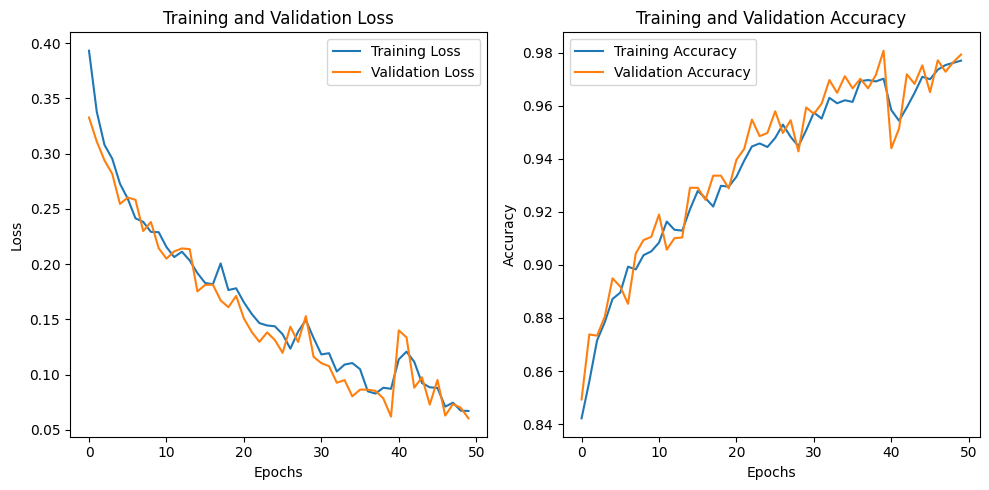

In [43]:
# access the loss values and accuracy values
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot loss & accuracy
axs[0].plot(loss_values, label='Training Loss')
axs[0].plot(val_loss_values, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()

axs[1].plot(accuracy_values, label='Training Accuracy')
axs[1].plot(val_accuracy_values, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()